---

<h1 style="text-align: center;font-size: 40px;">Cataract Prediction using vgg19</h1>

---

<h3>Dataset Information:</h3>
Ocular Disease Intelligent Recognition (ODIR) is a structured ophthalmic database of 5,000 patients with age, color fundus photographs from left and right eyes and doctors' diagnostic keywords from doctors.This dataset is meant to represent ‘‘real-life’’ set of patient information collected by Shanggong Medical Technology Co., Ltd. from different hospitals/medical centers in China. In these institutions, fundus images are captured by various cameras in the market, such as Canon, Zeiss and Kowa, resulting into varied image resolutions.Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:

- Normal (N),
- Diabetes (D),
- Glaucoma (G),
- Cataract (C),
- Age related Macular Degeneration (A),
- Hypertension (H),
- Pathological Myopia (M),
- Other diseases/abnormalities (O)

- Here i'm going to make a model which is going to  predict an image is belongs to Normal or Cataract category!

In [1]:
import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df_data2 = df.iloc[:, 1:7]

df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


> <h3> Extracting Cataract & Normal information from the Dataset </h3>

In [3]:
# def has_cataract(text):
#     if "cataract" in text:
#         return 1
#     else:
#         return 0

In [4]:
def search_keywords(data_frame, keyword):
    left_diagnosis = data_frame[data_frame['Left-Diagnostic Keywords'].str.contains(keyword)]['Left-Fundus'].values
    right_diagnosis = data_frame[data_frame['Right-Diagnostic Keywords'].str.contains(keyword)]['Right-Fundus'].values
    combined = np.concatenate((left_diagnosis, right_diagnosis))
    
    return combined

# Mencari semua kata kunci dalam satu langkah
image_arrays = {}

# Daftar kata kunci yang ingin dicari
keywords = ["cataract", "normal", "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma"]  # Ganti dengan kata kunci yang diinginkan

for keyword in keywords:
    images_for_keyword = search_keywords(df_data2, keyword)
    image_arrays[keyword] = images_for_keyword

# Menampilkan jumlah gambar untuk setiap kata kunci
for keyword, images in image_arrays.items():
    print(f"Number of images for {keyword}: {len(images)}")

# Combine all images for normal and conditions
all_images = np.concatenate(list(image_arrays.values()), axis=0)
print("Total number of images:", len(all_images))

# Convert image arrays to dictionary
class_images_dict = {keyword: images.tolist() for keyword, images in image_arrays.items()}

Number of images for cataract: 594
Number of images for normal: 5683
Number of images for myopia: 479
Number of images for hypertensive: 382
Number of images for diabetic: 165
Number of images for age-related macular degeneration: 551
Number of images for glaucoma: 616
Total number of images: 8470


In [5]:
# df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
# df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [6]:
# left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
# left_cataract[:15]

In [7]:
# right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
# right_cataract[:15]

In [8]:
# print("Number of images in left cataract: {}".format(len(left_cataract)))
# print("Number of images in right cataract: {}".format(len(right_cataract)))

>Normal Images

In [9]:
# left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
# right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
# right_normal[:15]

In [10]:
# cataract = np.concatenate((left_cataract,right_cataract),axis=0)
# normal = np.concatenate((left_normal,right_normal),axis=0)

In [11]:
# print(len(cataract),len(normal))

><h3>Creating Dataset from images</h3>

In [12]:
from imblearn.over_sampling import RandomOverSampler

IMG_SIZE = 224

def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    non_0_rows = np.array([row_idx for row_idx, row in enumerate(img) if np.count_nonzero(row)!=0])
    non_0_cols = np.array([col_idx for col_idx, col in enumerate(img.transpose(1,0,2)) if np.count_nonzero(col)!=0])
    img = img[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
    img = cv2.resize(img, target_shape)
    return img

def median_filter(image, kernel_size):
    # Pastikan ukuran kernel ganjil
    if kernel_size % 2 == 0:
        kernel_size += 1

    # Lakukan filter median
    filtered_image = cv2.medianBlur(image, kernel_size)

    return filtered_image

# Fungsi untuk Gaussian blur menggunakan cv2.GaussianBlur
def gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)

# Fungsi untuk melakukan histogram equalization pada gambar
def histogram_equalization(image):
    # Ubah gambar ke skala keabuan jika belum
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image

    # Lakukan histogram equalization
    equalized = cv2.equalizeHist(gray)

    equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2RGB)
    
    kernel_size = 5
    
    filtered = gaussian_blur(equalized)
#     filtered = median_filter(equalized, kernel_size)
#     filtered = wiener_filter(equalized)

    return filtered

def create_dataset_with_oversampling(dataset_dir, class_images_dict, image_size=(224, 224)):
    dataset = []
    labels = list(class_images_dict.keys())

    for class_name, image_category in class_images_dict.items():
        for img in tqdm(image_category, desc=f"Processing {class_name} images"):
            image_path = os.path.join(dataset_dir, img)
            try:
                image = load_prep_img(image_path)
#                 image = histogram_equalization(image)
            except:
                continue

            # Assuming the class labels are encoded as integers
            label = np.array(labels.index(class_name))
            
            dataset.append([np.array(image), label])

    # Convert the dataset to a DataFrame
    df = pd.DataFrame(dataset, columns=['image', 'label'])

    # Convert labels to integers explicitly
    df['label'] = df['label'].astype(int)

    # Apply random oversampling
    oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = oversample.fit_resample(df['image'].values.reshape(-1, 1), df['label'])

    # Reconstruct the dataset
    resampled_dataset = [(X_resampled[i][0], y_resampled[i]) for i in range(len(X_resampled))]

    random.shuffle(resampled_dataset)
    return resampled_dataset, labels

# Placeholder arrays, replace these with actual arrays when available
cataract = class_images_dict.get('cataract', [])
normal = class_images_dict.get('normal', [])
diabetic = class_images_dict.get('diabetic', [])
amd = class_images_dict.get('age-related macular degeneration', [])
glaucoma = class_images_dict.get('glaucoma', [])
myopia = class_images_dict.get('myopia', [])
hypertensive = class_images_dict.get('hypertensive', [])

# Assuming you have a dictionary of class images
class_images_dict = {
    'cataract': cataract,
    'normal': normal,
    'diabetic': diabetic,
    'age-related macular degeneration': amd,
    'glaucoma': glaucoma,
    'myopia': myopia,
    'hypertensive': hypertensive
}

dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/"
# dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/"
dataset, labels = create_dataset_with_oversampling(dataset_dir, class_images_dict)
print("Total number of images in the dataset:", len(dataset))

Processing normal images:   4%|▎         | 201/5683 [00:04<02:07, 43.00it/s][ WARN:0@26.408] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1062_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@26.429] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1077_left.jpg'): can't open/read file: check file path/integrity
Processing normal images:   7%|▋         | 424/5683 [00:08<01:59, 43.84it/s][ WARN:0@31.113] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2495_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@31.114] global loadsave.cpp:248 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2496_left.jpg'): can't open/read file: check file path/integrity
Processing normal images:  11%|█▏        | 643/5683 [00:13<02:00, 41

Total number of images in the dataset: 39172


In [13]:
# from tensorflow.keras.preprocessing.image import load_img,img_to_array
# dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/"
# image_size=224
# target_size = (224, 224)  # Ubah ukuran sesuai kebutuhan Anda
# labels = []
# dataset = []
# def resize_image(img, target_size):
#     # Mendapatkan dimensi gambar asli
#     original_height, original_width = img.shape[:2]

#     # Mendapatkan dimensi target
#     target_width, target_height = target_size

#     # Menghitung rasio skala lebar dan tinggi
#     width_ratio = target_width / original_width
#     height_ratio = target_height / original_height

#     # Menentukan rasio skala yang akan digunakan untuk resizing
#     scale_ratio = min(width_ratio, height_ratio)

#     # Menghitung ukuran baru setelah penskalaan
#     new_width = int(original_width * scale_ratio)
#     new_height = int(original_height * scale_ratio)

#     # Melakukan resizing gambar dengan opsi interporasi yang baik
#     resized_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

#     # Membuat latar belakang gambar dengan ukuran target
#     background = (0, 0, 0)  # Hitam

#     # Membuat gambar dengan ukuran target yang tepat
#     top_padding = (target_height - new_height) // 2
#     bottom_padding = target_height - new_height - top_padding
#     left_padding = (target_width - new_width) // 2
#     right_padding = target_width - new_width - left_padding

#     # Menggunakan padding untuk membuat latar belakang dengan ukuran target
#     background_img = cv2.copyMakeBorder(resized_img, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=background)

#     return background_img

# def crop_image(image_file):
#     img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
#     img_copy=img.copy()
#     lower=np.array([10,10,10])
#     higher=np.array([250,250,250])
#     mask=cv2.inRange(img, lower, higher)
#     contours, hierarchy = cv2.findContours(image= mask,
#                                            mode=cv2.RETR_EXTERNAL,
#                                            method=cv2.CHAIN_APPROX_NONE)
#     sorted_contours=sorted(contours, key=cv2.contourArea, reverse= True) 

#     cont_img=cv2.drawContours(image=img, contours=sorted_contours, contourIdx=0, 
#                               color=(0,255,0),thickness=3)
#     c=sorted_contours[0]
#     x,y,w,h = cv2.boundingRect(c) 
#     cv2.rectangle(img=img, pt1=(x,y), pt2=(x+w,y+h), color=(0,255,0), thickness=3)
#     cropped_image=img_copy[y:y+h+1, x:x+w+1]
#     return cropped_image

# IMG_SIZE = 224

# def load_prep_img(image_path, target_shape=(IMG_SIZE, IMG_SIZE)):
#     img = cv2.imread(image_path, cv2.IMREAD_COLOR)
# #     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
#     non_0_rows = np.array([row_idx for row_idx, row in enumerate(img) if np.count_nonzero(row)!=0])
#     non_0_cols = np.array([col_idx for col_idx, col in enumerate(img.transpose(1,0,2)) if np.count_nonzero(col)!=0])
#     img = img[non_0_rows.min():non_0_rows.max()+1, non_0_cols.min():non_0_cols.max()+1, :] # clip
#     img = cv2.resize(img, target_shape)
#     return img

# def resize_and_crop_image(image_path, target_size):
#     # Read the image
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     # Resize the image
#     img = resize_image(img, target_size)

#     # Crop the image
#     img = crop_image(img)

#     return img

# def median_filter(image, kernel_size):
#     # Pastikan ukuran kernel ganjil
#     if kernel_size % 2 == 0:
#         kernel_size += 1

#     # Lakukan filter median
#     filtered_image = cv2.medianBlur(image, kernel_size)

#     return filtered_image

# # Fungsi untuk melakukan histogram equalization pada gambar
# def histogram_equalization(image):
#     # Ubah gambar ke skala keabuan jika belum
#     if len(image.shape) > 2:
#         gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     else:
#         gray = image

#     # Lakukan histogram equalization
#     equalized = cv2.equalizeHist(gray)

#     equalized = cv2.cvtColor(equalized, cv2.COLOR_GRAY2BGR)
    
#     kernel_size = 5
    
# #     filtered = gaussian_blur(equalized)
#     filtered = median_filter(equalized, kernel_size)
# #     filtered = wiener_filter(equalized)

#     return filtered

# # def create_dataset(image_category,label):
# #     for img in tqdm(image_category):
# #         image_path = os.path.join(dataset_dir,img)
# #         try:
# # #             image = load_prep_img(image_path)
# #             image = cv2.imread(image_path,cv2.IMREAD_COLOR)
# # #             image = cv2.resize(image,(image_size,image_size))
# #             image = resize_image(image,target_size)
# #             image = crop_image(image)
# #         except:
# #             continue
        
# #         dataset.append([np.array(image),np.array(label)])
# #     random.shuffle(dataset)
# #     return dataset

# def create_dataset(dataset_dir, class_images_dict, image_size=(224, 224)):
#     dataset = []
#     labels = list(class_images_dict.keys())

#     for class_name, image_category in class_images_dict.items():
#         for img in tqdm(image_category, desc=f"Processing {class_name} images"):
#             image_path = os.path.join(dataset_dir, img)
#             try:
# #                 image = cv2.imread(image_path, cv2.IMREAD_COLOR)
#                 image = load_prep_img(image_path)
# #                 image = cv2.resize(image, image_size)
#                 image = histogram_equalization(image)
#             except:
#                 continue

#             # Assuming the class labels are encoded as integers
#             label = np.array(labels.index(class_name))
            
#             dataset.append([np.array(image), label])

#     random.shuffle(dataset)
#     return dataset, labels

# # Placeholder arrays, replace these with actual arrays when available
# cataract = class_images_dict.get('cataract', [])
# normal = class_images_dict.get('normal', [])
# diabetic = class_images_dict.get('diabetic', [])
# amd = class_images_dict.get('age-related macular degeneration', [])
# glaucoma = class_images_dict.get('glaucoma', [])
# myopia = class_images_dict.get('myopia', [])
# hypertensive = class_images_dict.get('hypertensive', [])

# # Assuming you have a dictionary of class images
# class_images_dict = {
#     'cataract': cataract,
#     'normal': normal,
#     'diabetic': diabetic,
#     'age-related macular degeneration': amd,
#     'glaucoma': glaucoma,
#     'myopia': myopia,
#     'hypertensive': hypertensive
# }

# dataset, labels = create_dataset(dataset_dir, class_images_dict)
# print("Total number of images in the dataset:", len(dataset))

In [14]:
# dataset = create_dataset(cataract,1)

In [15]:
# len(dataset)

In [16]:
# dataset = create_dataset(normal,0)

In [17]:
# len(dataset)

In [18]:
# # Assuming y_train_labels is your target variable after oversampling
# class_labels, class_counts = np.unique(y_train_labels, return_counts=True)

# plt.bar(class_labels, class_counts, align='center')
# plt.xlabel('Class Labels')
# plt.ylabel('Count')
# plt.title('Class Distribution after Oversampling')
# plt.show()

><h3>Let's see some images</h3>

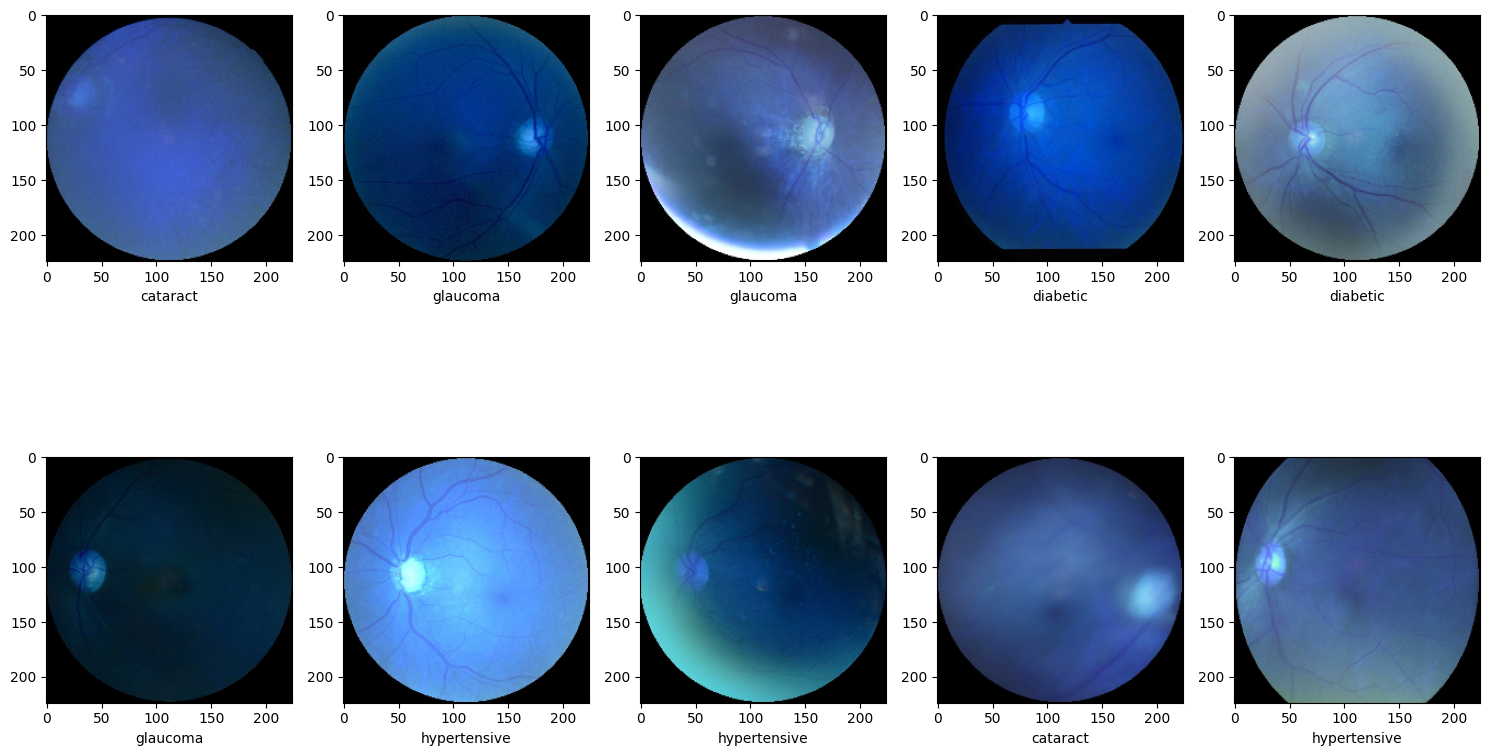

In [19]:
# plt.figure(figsize=(12,7))
# for i in range(10):
#     sample = random.choice(range(len(dataset)))
#     image = dataset[sample][0]
#     category = dataset[sample][1]
#     if category== 0:
#         label = "Normal"
#     else:
#         label = "Cataract"
#     plt.subplot(2,5,i+1)
#     plt.imshow(image)
#     plt.xlabel(label)
# plt.tight_layout()

# Gantilah X dan y dengan variabel yang sesuai pada saat membuat dataset
plt.figure(figsize=(15, 10))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    label_id = dataset[sample][1]
    
    # Konversi label_id ke label yang sesuai
    labels = ['cataract', 'normal', 'diabetic', 'age-related macular degeneration', 'glaucoma', 'myopia', 'hypertensive']
    label = labels[label_id]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.xlabel(label)

plt.tight_layout()
plt.show()

><h3>Dividing dataset into x(features) & y(target)</h3>

In [20]:
# x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
# y = np.array([i[1] for i in dataset])
from tensorflow.keras.utils import to_categorical
# Assuming num_classes is defined and set to 7
num_classes = len(class_images_dict)

# Convert labels to one-hot encoded format
y = np.array([i[1] for i in dataset])
y_onehot = to_categorical(y, num_classes=num_classes)

In [21]:
from sklearn.model_selection import train_test_split
# # x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3)

# Split the dataset into training and testing sets
image_size=224
x = np.array([i[0] for i in dataset]).reshape(-1, image_size, image_size, 3)
x_train, x_test, y_train, y_test = train_test_split(x, y_onehot, test_size=0.3)

# # Assuming x and y_onehot are your data and one-hot encoded labels
# x_train, x_test, y_train_onehot, y_test_onehot = train_test_split(x, y_onehot, test_size=0.3)

# # Convert one-hot encoded labels to categorical labels
# y_train_labels = np.argmax(y_train_onehot, axis=1)
# y_test_labels = np.argmax(y_test_onehot, axis=1)

><h3>Creating Model</h3>

In [22]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
# from tensorflow.keras.utils import to_categorical
# from sklearn.model_selection import train_test_split
# import datetime
# from tensorflow.keras.callbacks import TensorBoard
# import numpy as np
# import random

# # Assuming num_classes is defined and set to 7
# num_classes = 7

# # Convert labels to one-hot encoded format
# y_train_onehot = to_categorical(y_train, num_classes=num_classes)
# y_test_onehot = to_categorical(y_test, num_classes=num_classes)

# # Assuming image size is defined
# image_size = 224

# # Preprocess input data (VGG19-specific)
# x_train_preprocessed = preprocess_input(x_train)
# x_test_preprocessed = preprocess_input(x_test)

# # Create your model architecture
# def create_model(input_shape, num_classes):
#     vgg = VGG19(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))
    
#     for layer in vgg.layers:
#         layer.trainable = False
    
#     model = Sequential()
#     model.add(vgg)
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dropout(0.25))
#     model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
#     model.add(BatchNormalization())
#     model.add(Dense(num_classes, activation="softmax"))
    
#     optimizer = Adam(learning_rate=0.01)
#     model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#     return model

# # Define callbacks
# checkpoint = ModelCheckpoint('model_best.h5', monitor='val_loss', save_best_only=True, verbose=1)
# earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

# # Create and compile the model
# model = create_model((image_size, image_size, 3), num_classes)

# # Train the model
# history = model.fit(x_train_preprocessed, y_train_onehot, validation_data=(x_test_preprocessed, y_test_onehot),
#                     epochs=50, batch_size=32, callbacks=[checkpoint, earlystop, reduce_lr])

# # Evaluate the model
# loss, accuracy = model.evaluate(x_test_preprocessed, y_test_onehot)
# print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

# # Define your model architecture (as you provided)
# def create_model(input_shape, num_classes):
#     vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))
    
#     for layer in vgg.layers:
#         layer.trainable = False
    
#     model = Sequential()
#     model.add(vgg)
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, 3)))
#     model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dropout(0.25))
#     model.add(Dense(512, activation='relu', kernel_regularizer='l2'))
#     model.add(BatchNormalization())
#     model.add(Dense(num_classes, activation="softmax"))
    
# #     model.summary()

#     optimizer = Adam(learning_rate=0.01)
#     model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#     return model

# # Load your data and create datasets
# # Assuming x_train, y_train, x_test, y_test are already defined

# # Assuming num_classes is defined and set to 7
# num_classes = 7

# # Convert labels to one-hot encoded format
# y_train_onehot = to_categorical(y_train, num_classes=num_classes)
# y_test_onehot = to_categorical(y_test, num_classes=num_classes)

# # Assuming image size is defined
# image_size = 224

# # Create multiple instances of the model
# num_models = 5  # You can adjust the number of models based on your preference
# models = [create_model((image_size, image_size, 3), num_classes) for _ in range(num_models)]

# # Training each model independently
# histories = []
# for i, model in enumerate(models):
#     print(f"Training Model {i + 1}")
    
#     checkpoint = ModelCheckpoint(f'model_{i + 1}.h5', monitor='val_loss', save_best_only=True, verbose=1,
#                                  save_weights_only=False, period=1)
#     earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
#     lr_scheduler = LearningRateScheduler(lambda epoch: 0.01 if epoch > 10 else (0.1 if epoch > 5 else 1.0))

#     history = model.fit(x_train, y_train_onehot, steps_per_epoch=len(x_train) / 32, batch_size=32, epochs=50,
#                         validation_data=(x_test, y_test_onehot), verbose=1, callbacks=[checkpoint, earlystop, lr_scheduler])
    
#     histories.append(history)

# # Combine logits (predictions before softmax) from all models
# ensemble_logits = np.zeros_like(y_test_onehot)
# for model in models:
#     ensemble_logits += model.predict(x_test, logits=True)  # Ensure your model has logits=True

# # Average logits from all models
# ensemble_logits /= num_models

# # Convert logits to probabilities using softmax
# ensemble_predictions_prob = softmax(ensemble_logits, axis=1)

# print(f"Ensemble Model - Loss: {ensemble_loss:.4f}, Accuracy: {ensemble_accuracy * 100:.2f}%")

In [23]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 [==============================] - 0s 0us/step


In [24]:
for layer in vgg.layers:
    layer.trainable = False

In [25]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
from keras import applications, regularizers
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout, Activation, BatchNormalization
# model = Sequential()
# model.add(vgg)
# model.add(Flatten())
# model.add(Dense(7,activation="sigmoid"))
# Definisikan parameter untuk pelatihan model

num_classes = 7

model = Sequential()
model.add(vgg)
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(num_classes,activation="softmax"))

In [26]:
# model.summary()

In [27]:
from keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Learning Rate Schedule
def lr_schedule(epoch):
    lr = 0.01
    if epoch > 10:
        lr *= 0.1
    elif epoch > 5:
        lr *= 0.5
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

In [28]:
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
# checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_loss",verbose=1,save_best_only=True,
#                              save_weights_only=False,period=1)
# earlystop = EarlyStopping(monitor="val_loss",patience=5,verbose=1)

checkpoint = ModelCheckpoint('model_vgg19.save', monitor='val_loss', save_best_only=True, verbose=1,save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
log_dir = "logs/fit_vgg/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [29]:
history = model.fit(x_train,y_train,steps_per_epoch=len(x_train) / 32, batch_size=32,epochs=50,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop, lr_scheduler])

# from sklearn.utils.class_weight import compute_sample_weight

# # Calculate class weights
# sample_weights = compute_sample_weight('balanced', y_train_labels)

# # Convert class weights to a dictionary
# class_weight_dict = dict(zip(np.unique(y_train_labels), sample_weights))

# # Use class weights in model.fit
# history = model.fit(x_train, y_train, steps_per_epoch=len(x_train) / 32, batch_size=32, epochs=15, validation_data=(x_test, y_test),
#                     class_weight=class_weight_dict, verbose=1, callbacks=[checkpoint, earlystop, lr_scheduler])

Epoch 1/50
857/856 [==============================] - ETA: 0s - loss: 2.1485 - accuracy: 0.5851
Epoch 1: val_loss improved from inf to 4662.63525, saving model to model_vgg19.save
856/856 [==============================] - 116s 123ms/step - loss: 2.1485 - accuracy: 0.5851 - val_loss: 4662.6353 - val_accuracy: 0.1453 - lr: 0.0100
Epoch 2/50
857/856 [==============================] - ETA: 0s - loss: 3.1968 - accuracy: 0.8087
Epoch 2: val_loss improved from 4662.63525 to 2.84979, saving model to model_vgg19.save
856/856 [==============================] - 97s 114ms/step - loss: 3.1968 - accuracy: 0.8087 - val_loss: 2.8498 - val_accuracy: 0.8325 - lr: 0.0100
Epoch 3/50
857/856 [==============================] - ETA: 0s - loss: 2.4751 - accuracy: 0.8833
Epoch 3: val_loss improved from 2.84979 to 2.15263, saving model to model_vgg19.save
856/856 [==============================] - 98s 114ms/step - loss: 2.4751 - accuracy: 0.8833 - val_loss: 2.1526 - val_accuracy: 0.8843 - lr: 0.0100
Epoch 4/50

In [30]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

368/368 [==============================] - 28s 76ms/step - loss: 0.1262 - accuracy: 0.9546
loss: 0.12621374428272247
Accuracy: 0.9546459913253784


In [31]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
# y_pred = model.predict_classes(x_test)

# Assuming model.predict returns probabilities for each class
y_pred_prob = model.predict(x_test)

# Convert probabilities to class labels (use argmax along axis 1)
y_pred = np.argmax(y_pred_prob, axis=1)

# If y_test is one-hot encoded, convert it back to class labels
y_test_labels = np.argmax(y_test, axis=1)

print("Shape of y_test_labels:", y_test_labels.shape)
print("Shape of y_pred:", y_pred.shape)

368/368 [==============================] - 27s 72ms/step
Shape of y_test_labels: (11752,)
Shape of y_pred: (11752,)


In [32]:
model.save("eyedisease.h5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [33]:
# accuracy_score(y_test,y_pred)

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9546460176991151


In [34]:
# print(classification_report(y_test,y_pred))

# Assuming y_test_labels and y_pred are available
print(classification_report(y_test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1691
           1       1.00      0.98      0.99      1699
           2       0.87      1.00      0.93      1655
           3       0.97      0.91      0.94      1617
           4       0.96      0.88      0.92      1644
           5       0.97      1.00      0.98      1707
           6       0.96      0.92      0.94      1739

    accuracy                           0.95     11752
   macro avg       0.96      0.95      0.95     11752
weighted avg       0.96      0.95      0.95     11752



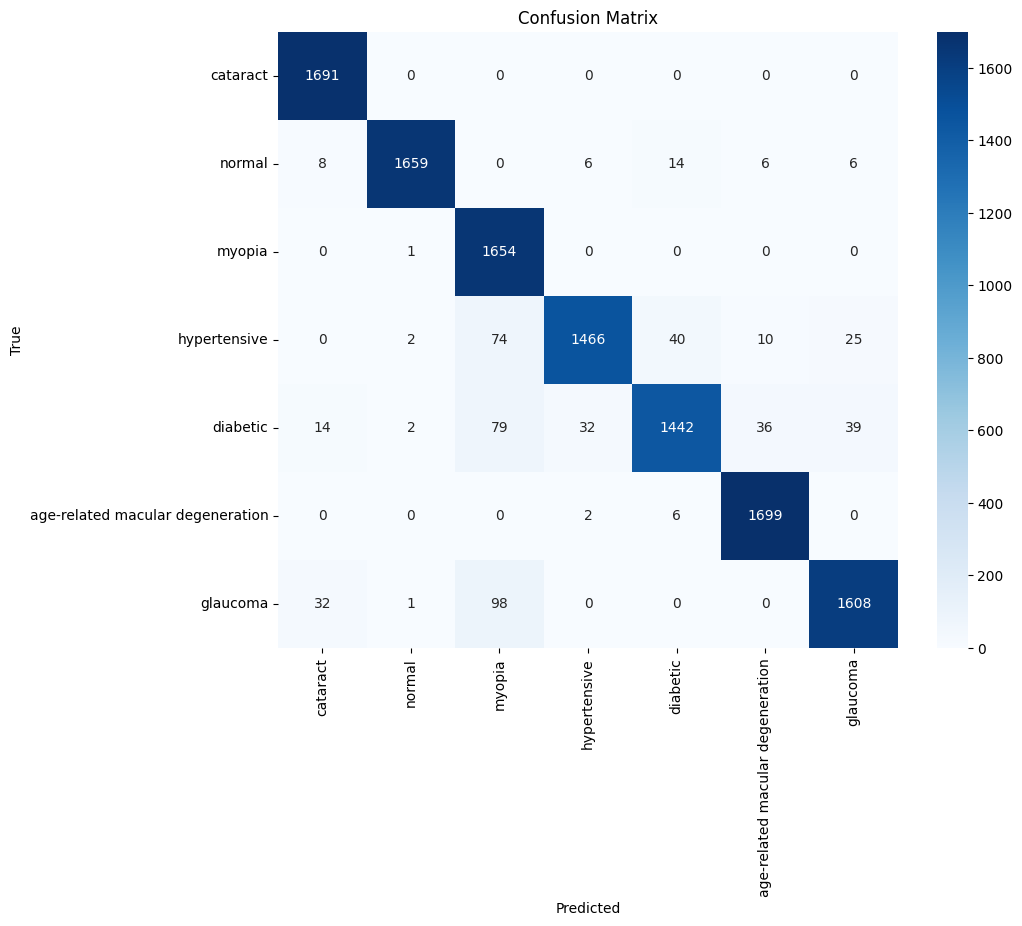

                                  precision    recall  f1-score   support

                        cataract       0.97      1.00      0.98      1691
                          normal       1.00      0.98      0.99      1699
                          myopia       0.87      1.00      0.93      1655
                    hypertensive       0.97      0.91      0.94      1617
                        diabetic       0.96      0.88      0.92      1644
age-related macular degeneration       0.97      1.00      0.98      1707
                        glaucoma       0.96      0.92      0.94      1739

                        accuracy                           0.95     11752
                       macro avg       0.96      0.95      0.95     11752
                    weighted avg       0.96      0.95      0.95     11752



In [35]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
# cm = confusion_matrix(y_test,y_pred)
# plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
#                       show_normed = True);


# Assuming y_test_labels and y_pred are available
le = LabelEncoder()
y_test_labels_encoded = le.fit_transform(y_test_labels)
y_pred_encoded = le.transform(y_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels_encoded, y_pred_encoded)
class_names = ["cataract", "normal", "myopia", "hypertensive", "diabetic", "age-related macular degeneration", "glaucoma"]  # Ganti dengan kata kunci yang diinginkan

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display classification report
print(classification_report(y_test_labels_encoded, y_pred_encoded, target_names=class_names))

><h3>Learning Curve</h3>

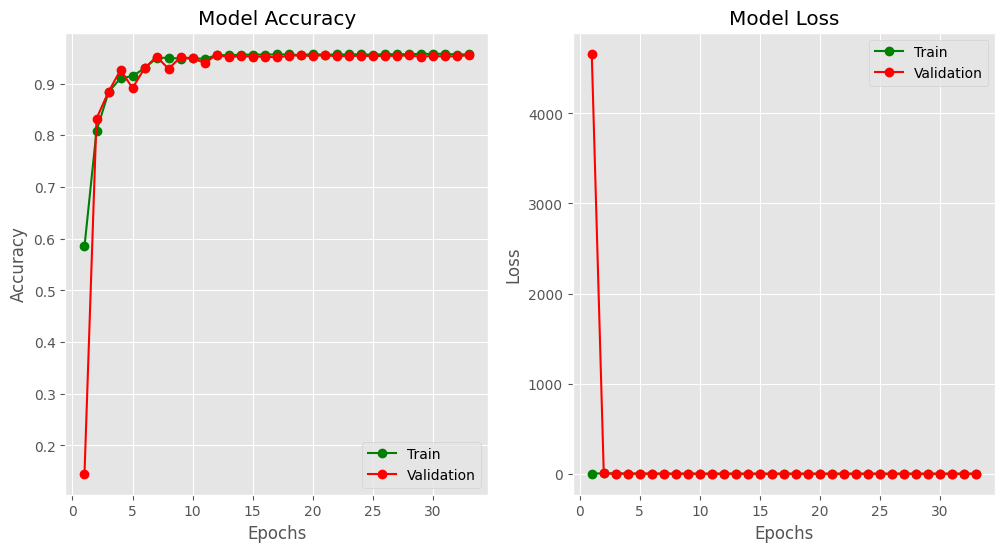

In [36]:
# plt.style.use("ggplot")
# fig = plt.figure(figsize=(12,6))
# epochs = range(1,16)
# plt.subplot(1,2,1)
# plt.plot(epochs,history.history["accuracy"],"go-")
# plt.plot(epochs,history.history["val_accuracy"],"ro-")
# plt.title("Model Accuracy")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy")
# plt.legend(["Train","val"],loc = "upper left")

# plt.subplot(1,2,2)
# plt.plot(epochs,history.history["loss"],"go-")
# plt.plot(epochs,history.history["val_loss"],"ro-")
# plt.title("Model Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend(["Train","val"],loc = "upper left")
# plt.show()

plt.style.use("ggplot")
fig = plt.figure(figsize=(12, 6))

# Extract the actual number of epochs from the training history
epochs = range(1, len(history.history['accuracy']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train", "Validation"], loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"], loc="upper right")

plt.show()

><h3>Prediction:</h3>

1/1 [==============================] - 0s 23ms/step


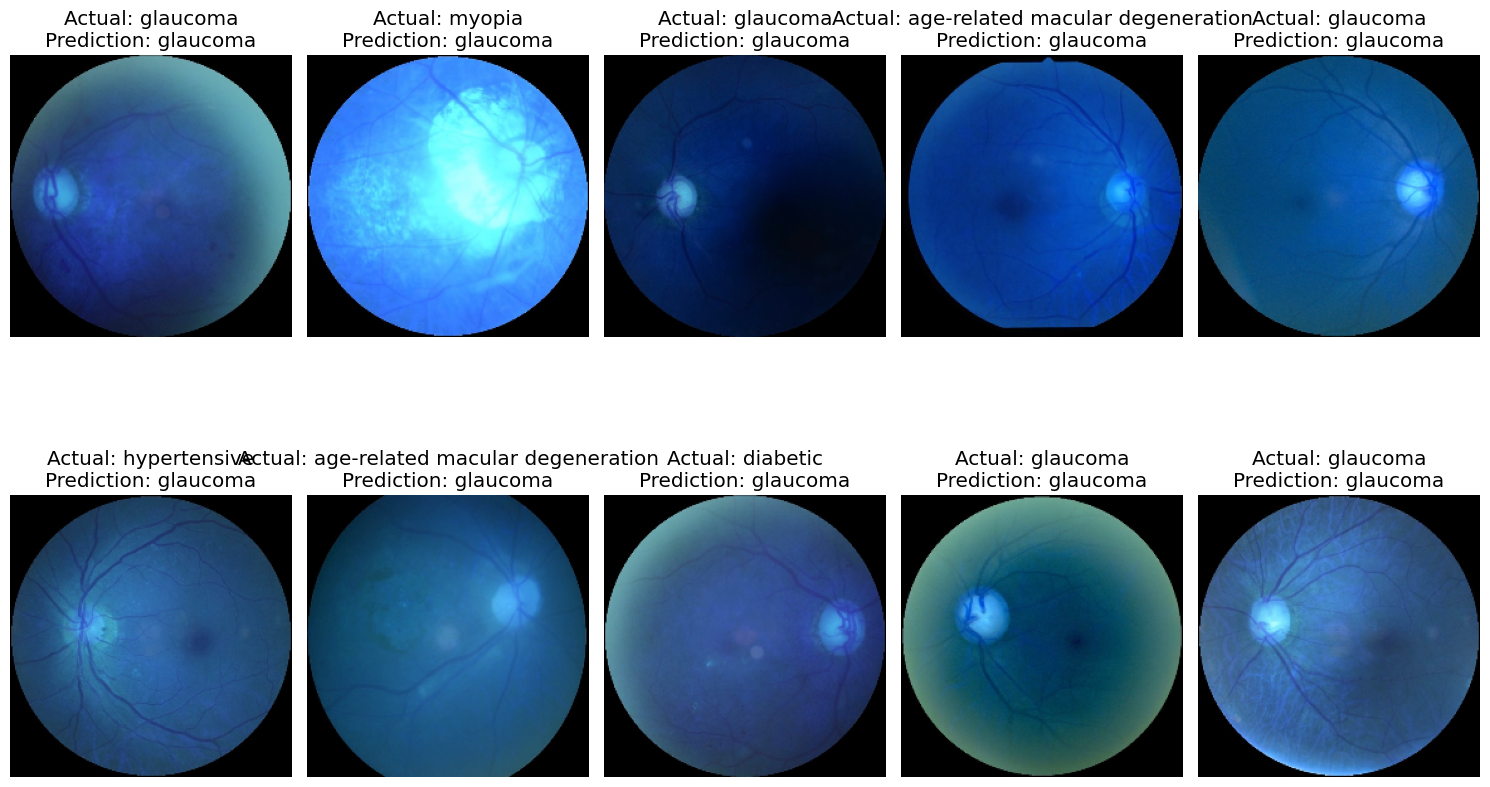

In [37]:
# plt.figure(figsize=(12,7))
# for i in range(10):
#     sample = random.choice(range(len(x_test)))
#     image = x_test[sample]
#     category = y_test[sample]
#     pred_category = y_pred[sample]
    
#     if category== 0:
#         label = "Normal"
#     else:
#         label = "Cataract"      
#     if pred_category== 0:
#         pred_label = "Normal"
#     else:
#         pred_label = "Cataract"   
#     plt.subplot(2,5,i+1)
#     plt.imshow(image)
#     plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
# plt.tight_layout() 

# Map class indices to class names
class_names = ['cataract', 'normal', 'diabetic', 'age-related macular degeneration', 'glaucoma', 'myopia', 'hypertensive']

plt.figure(figsize=(15, 10))

# Select a random sample of images
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    actual_category = class_names[np.argmax(y_test[sample])]  # Convert one-hot encoded to class name
    pred_category_probs = model.predict(np.expand_dims(image, axis=0))[0]  # Prediction probabilities for all classes

    # Set a custom threshold (you can experiment with different values)
    threshold = 0.5

    # Get the predicted categories above the threshold
    pred_categories_above_threshold = [class_names[idx] for idx, prob in enumerate(pred_category_probs) if prob > threshold]

    # If no class is above the threshold, select the one with the highest probability
    if not pred_categories_above_threshold:
        pred_category = class_names[np.argmax(pred_category_probs)]
    else:
        pred_category = ', '.join(pred_categories_above_threshold)

    plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title("Actual: {}\nPrediction: {}".format(actual_category, pred_category))
    plt.axis('off')

plt.tight_layout()
plt.show()

---

<h1 style="text-align: center;font-size: 20px;">Thanks for Reading!!</h1>

---